In [158]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.io as skio
import scipy
import time
import os
from skimage.metrics import structural_similarity as ssim
from jpeg_class import JPEG
#import jpeg_class
#import importlib
#importlib.reload(jpeg_class)


# JPEG 

Image shape: (352, 800, 3)
Image data type: uint8
Theoretical uncompressed image size: 0.81 MB


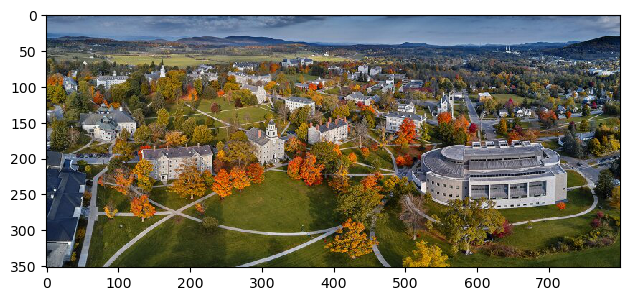

In [159]:
midd = skio.imread("images/midd.jpeg")
midd = midd[1:,  ] # should standardize this to blocks
skio.imshow(midd)

print(f'Image shape: {midd.shape}')
print(f'Image data type: {midd.dtype}')
print(f'Theoretical uncompressed image size: {np.round(np.prod(np.asarray(midd.shape)) / (1024 ** 2),2)} MB')

Image shape: (2992, 2016, 3)
Image data type: uint8
Theoretical uncompressed image size: 17.26 MB


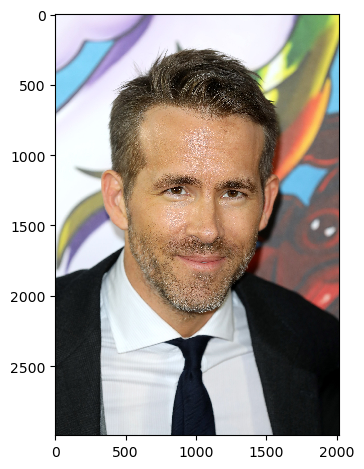

In [160]:
ryan = skio.imread("images/ryan.jpg")
ryan = ryan[8:,18:  ] # should standardize this to blocks
skio.imshow(ryan)

print(f'Image shape: {ryan.shape}')
print(f'Image data type: {ryan.dtype}')
print(f'Theoretical uncompressed image size: {np.round(np.prod(np.asarray(ryan.shape)) / (1024 ** 2),2)} MB')

Image shape: (4000, 6016, 3)
Image data type: uint8
Theoretical uncompressed image size: 68.85 MB


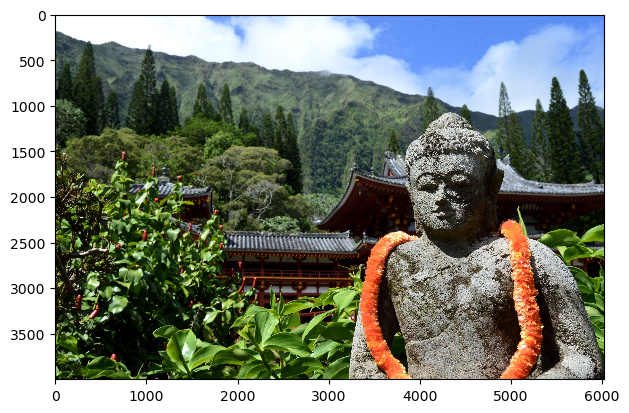

In [161]:
monk = skio.imread("images/monk.jpg")
skio.imshow(monk)

print(f'Image shape: {monk.shape}')
print(f'Image data type: {monk.dtype}')
print(f'Theoretical uncompressed image size: {np.round(np.prod(np.asarray(monk.shape)) / (1024 ** 2),2)} MB')

## Sample Compression

Here we save to disk, load that filepath, decode.

In [164]:

"""
Before anything else, choose what method you will use to dynamically quantize your image

D = "std_LoG"
D = "mean_LoG"
D = "std_saliency"
D = "mean_saliency"
D = "std_dctw"
D = "mean_dct"
"""

D = "std_LoG"

Original: 736.20 KB
Compression Time: 8.1s
Compressed: 123.59 KB


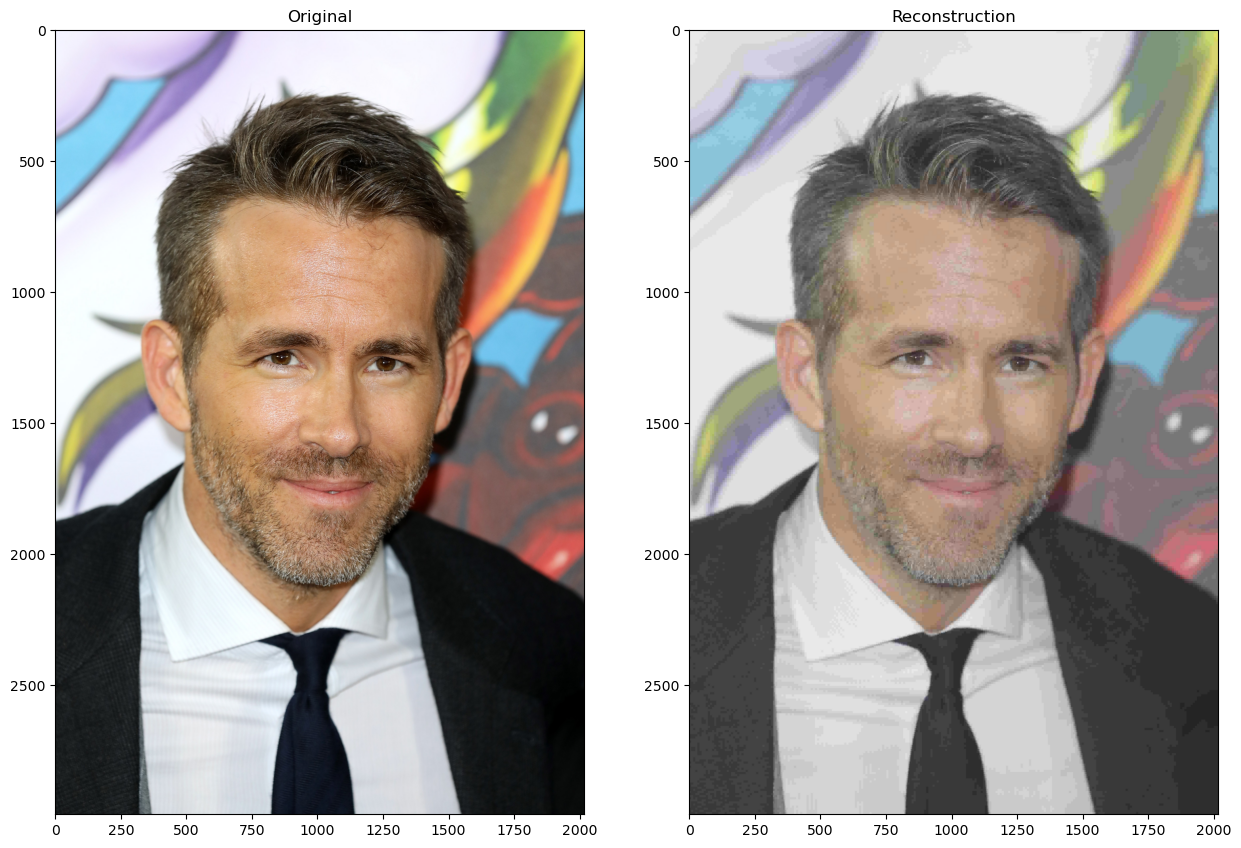

In [165]:
size = os.path.getsize("images/ryan.jpg")


print(f"Original: {size / 1024:.2f} KB")
current = time.time()
jpg = JPEG(ryan, downsample_ratio="4:2:0", q = 80, dynamic = True, dMode = D)
jpg.encode()
jpg.save_image("1.zst")

size = os.path.getsize("1.zst")
print(f"Compression Time: {np.round(time.time() - current, 1)}s")
print(f"Compressed: {size / 1024:.2f} KB")

jpg2 = JPEG.load_image("1.zst")
jpg2.decode()
jpg2.compare_image(ryan)

# Example: Dynamic vs. Fixed Quantization

Text(0.5, 1.0, 'Dynamic Quantization')

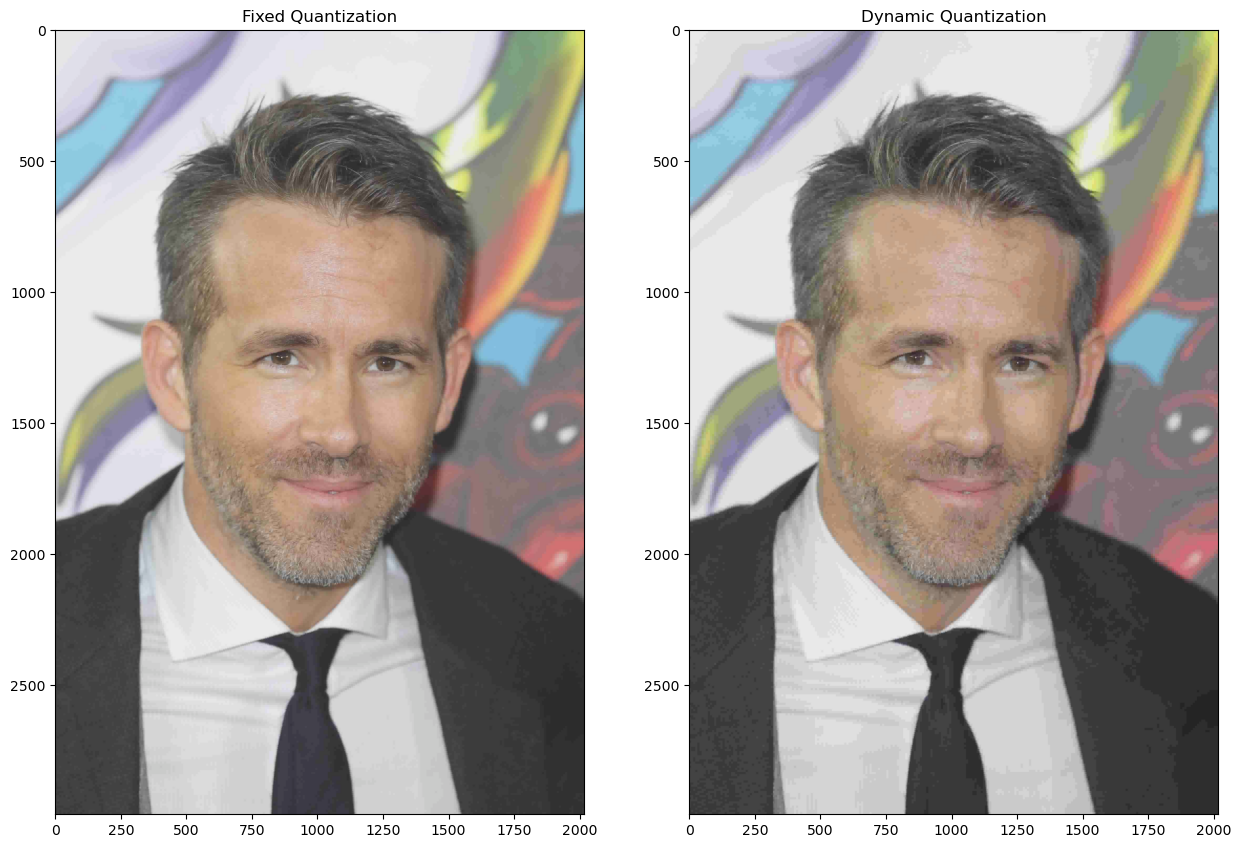

In [166]:
jpg = JPEG(ryan, downsample_ratio="4:2:0", q = 80, dynamic = False)
jpg.encode()
jpg.decode()

fig, axs = plt.subplots(1, 2)
fig.set_figheight(12)
fig.set_figwidth(15)

axs[0].imshow(jpg.img_array)
axs[0].set_title("Fixed Quantization")

axs[1].imshow(jpg2.img_array)
axs[1].set_title("Dynamic Quantization")

## Fixed Quantization: Plotting Quality vs File Size

Here I use 3 sample images and see how the quality affects the compressed file size.

In [171]:
def get_filesize(img, **kwargs):
    jpg = JPEG(img, **kwargs)
    jpg.encode()
    jpg.save_image("temp.zst")
    size = os.path.getsize("temp.zst")
    return size

In [170]:
def quality_vs_filesize(img, qualities, **kwargs):
    filesizes = []
    for quality in qualities:
        kwargs['q'] = quality
        filesize = get_filesize(img, **kwargs)
        filesizes.append(filesize)
    return np.asarray(filesizes)

In [167]:
qualities = range(100,50,-5)
# monk_fixed_filesizes = quality_vs_filesize(monk, qualities, downsample_ratio = "4:2:0")
midd_fixed_filesizes = quality_vs_filesize(midd, qualities, downsample_ratio = "4:2:0")
# ryan_fixed_filesizes = quality_vs_filesize(ryan, qualities, downsample_ratio = "4:2:0")

In [168]:
# monk_dyn_filesizes = quality_vs_filesize(monk, qualities, downsample_ratio = "4:2:0", dynamic = True, dMode = d)
midd_dyn_filesizes = quality_vs_filesize(midd, qualities, downsample_ratio = "4:2:0", dynamic = True, dMode = D)
# ryan_dyn_filesizes = quality_vs_filesize(ryan, qualities, downsample_ratio = "4:2:0", dynamic = True, dMode = d)

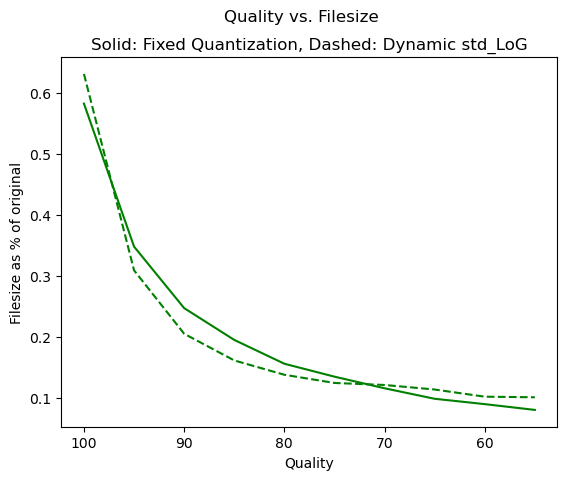

In [172]:
monk_size = os.path.getsize("images/monk.jpg")
midd_size = os.path.getsize("images/midd.jpeg")
ryan_size = os.path.getsize("images/ryan.jpg")
qualities = range(100,50,-5)

# plt.plot(qualities, monk_fixed_filesizes / monk_size, color = "red")
# plt.plot(qualities, ryan_fixed_filesizes / ryan_size, color = "blue")
plt.plot(qualities, midd_fixed_filesizes / midd_size, color = "green")

# plt.plot(qualities, monk_dyn_filesizes / monk_size, color = "red", linestyle = "dashed")
# plt.plot(qualities, ryan_dyn_filesizes / ryan_size, color = "blue", linestyle = "dashed")
plt.plot(qualities, midd_dyn_filesizes / midd_size, color = "green", linestyle = "dashed")

plt.gca().invert_xaxis()

plt.xlabel('Quality')
plt.ylabel('Filesize as % of original')
plt.suptitle('Quality vs. Filesize')
plt.title(f'Solid: Fixed Quantization, Dashed: Dynamic {D}')

plt.savefig('plots/quality_filesize.jpeg')

As you can see, there is an elbow in all the curves around 90-95 quality.  

Furthermore, when comparing each image's fixed vs dynamic quantization, we can see at the same quality the dynamic uses less space from around 80-95 quality.  Outside of that fixed takes up less space.

# Fixed Quantization: Plotting Quality vs SSIM

In [173]:
def get_ssim(img, **kwargs):
    jpg = JPEG(img, **kwargs)
    jpg.encode(max_step = 5) # everything after this is lossless so won't bother
    jpg.decode(from_step = 5)
    similarity = ssim(img, jpg.img_array, channel_axis = 2)
    return similarity

In [174]:
def quality_vs_ssim(img, qualities, **kwargs):
    ssims = []
    for quality in qualities:
        kwargs['q'] = quality
        local_ssim = get_ssim(img, **kwargs)
        ssims.append(local_ssim)
    return np.asarray(ssims)

In [184]:
qualities = range(100,46,-3)
# monk_fixed_ssim = quality_vs_ssim(monk, qualities, downsample_ratio = "4:2:0")
midd_fixed_ssim = quality_vs_ssim(midd, qualities, downsample_ratio = "4:2:0")
# ryan_fixed_ssim = quality_vs_ssim(ryan, qualities, downsample_ratio = "4:2:0")

In [185]:
# monk_dyn_ssim = quality_vs_ssim(monk, qualities, downsample_ratio = "4:2:0", dynamic = True, dMode = d)
midd_dyn_ssim = quality_vs_ssim(midd, qualities, downsample_ratio = "4:2:0", dynamic = True, dMode = D)
# ryan_dyn_ssim = quality_vs_ssim(ryan, qualities, downsample_ratio = "4:2:0", dynamic = True, dMode = d)

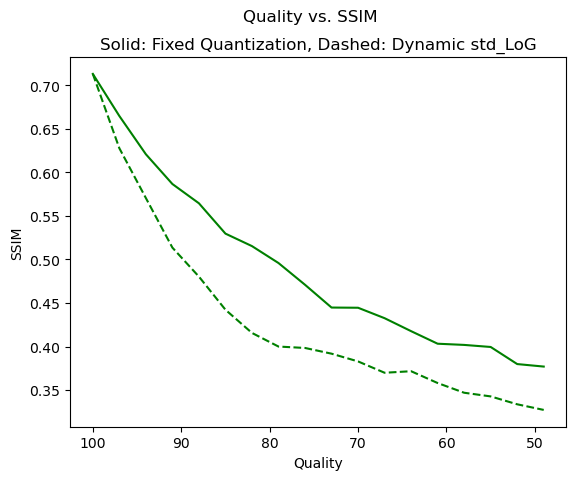

In [186]:
qualities = range(100,46,-3)

# plt.plot(qualities, monk_fixed_ssim, color = "red")
# plt.plot(qualities, ryan_fixed_ssim, color = "blue")
plt.plot(qualities, midd_fixed_ssim, color = "green")

# plt.plot(qualities, monk_dyn_ssim, color = "red", linestyle = "dashed")
# plt.plot(qualities, ryan_dyn_ssim, color = "blue", linestyle = "dashed")
plt.plot(qualities, midd_dyn_ssim, color = "green", linestyle = "dashed")

plt.gca().invert_xaxis()

plt.xlabel('Quality')
plt.ylabel('SSIM')
plt.suptitle('Quality vs. SSIM')
plt.title(f'Solid: Fixed Quantization, Dashed: Dynamic {D}')

plt.savefig("plots/quality_ssim.jpg")

# Fixed Quantization: Filesize vs SSIM

In [178]:
qualities = range(100,75,-3)
# monk_fixed_filesizes_75 = quality_vs_filesize(monk, qualities, downsample_ratio = "4:2:0")
midd_fixed_filesizes_75 = quality_vs_filesize(midd, qualities, downsample_ratio = "4:2:0")
# ryan_fixed_filesizes_75 = quality_vs_filesize(ryan, qualities, downsample_ratio = "4:2:0")

# monk_dyn_filesizes_75 = quality_vs_filesize(monk, qualities, downsample_ratio = "4:2:0", dynamic = True)
midd_dyn_filesizes_75 = quality_vs_filesize(midd, qualities, downsample_ratio = "4:2:0", dynamic = True, dMode = D)
# ryan_dyn_filesizes_75 = quality_vs_filesize(ryan, qualities, downsample_ratio = "4:2:0", dynamic = True)

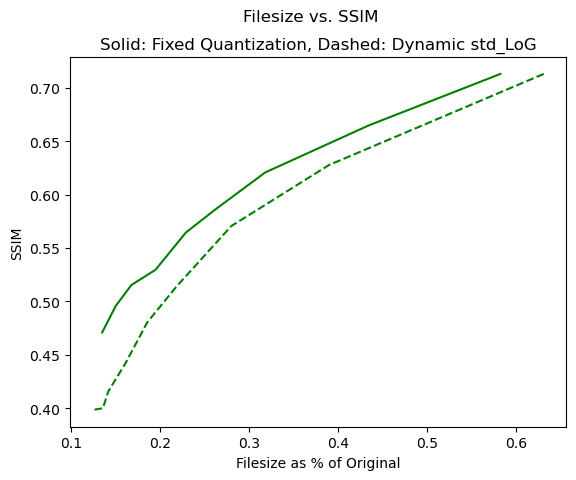

In [181]:
# plt.plot(monk_fixed_filesizes_75 / monk_size, monk_fixed_ssim, color = "red")
# plt.plot(ryan_fixed_filesizes_75 / ryan_size, ryan_fixed_ssim, color = "blue")
plt.plot(midd_fixed_filesizes_75 / midd_size, midd_fixed_ssim, color = "green")

# plt.plot(monk_dyn_filesizes_75 / monk_size, monk_dyn_ssim, color = "red", linestyle = "dashed")
# plt.plot(ryan_dyn_filesizes_75 / ryan_size, ryan_dyn_ssim, color = "blue", linestyle = "dashed")
plt.plot(midd_dyn_filesizes_75 / midd_size, midd_dyn_ssim, color = "green", linestyle = "dashed")

plt.xlabel('Filesize as % of Original')
plt.ylabel('SSIM')
plt.suptitle('Filesize vs. SSIM')
plt.title(f'Solid: Fixed Quantization, Dashed: Dynamic {D}')

plt.savefig("plots/filesize_quality.jpg")

# Example Gradient of Qualities

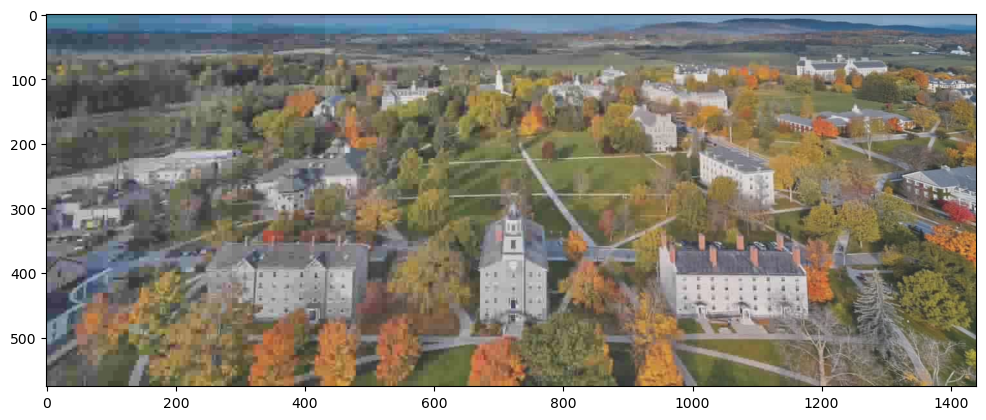

In [ ]:
midd2 = skio.imread("images/midd2.jpeg")

gradient_img = np.zeros_like(midd2)

for i in range(1,11):
    jpg = JPEG(midd2, q = 50 + i * 5, downsample_ratio = "4:2:0") # only going from 50 to 100
    jpg.encode()
    jpg.decode()
    gradient_img[:, ((i - 1) * midd2.shape[1] // 10): i * midd2.shape[1] // 10, :] = \
        jpg.img_array[:, ((i - 1) * midd2.shape[1] // 10): i * midd2.shape[1] // 10, :]


plt.figure(figsize=(12, 8))
plt.imshow(gradient_img)

plt.savefig("plots/gradient_img.jpg")